In [1]:
import os
import pandas as pd
import optuna
import numpy as np
from qiskit.circuit import QuantumCircuit
from qiskit.primitives import Estimator

import qtpu
from qtpu.compiler.compiler import compile_reach_size

from benchmark._plot_util import *

from benchmark.ansatz import generate_ansatz, qaoa2
from benchmark.util import get_info, append_to_csv
from qtpu.circuit import cuts_to_moves
from benchmark.exec_qtpu import qtpu_execute_cutensor
from qtpu.contract import contract
from qtpu.circuit import circuit_to_hybrid_tn
from circuit_knitting.cutting.qpd import TwoQubitQPDGate

In [20]:
df1 = pd.read_csv("../07_approx.csv")

df1 = df1[df1["tolerance"] < 1.0]
df1["tolerance"] *= 100
df1["time"] = df1["qtpu_gpu_pre"] + df1["qtpu_gpu_comp"] + df1["qtpu_gpu_post"] + df1["qtpu_gpu_run"]
df1["time"]

df1 = df1.groupby(["try", "tolerance"]).mean()

# Reset the index to make 'try' and 'tolerance' columns instead of index
df1 = df1.reset_index()

# Get the baseline time where "tolerance" = 0 for each "try"
baseline = df1[df1["tolerance"] == 0].set_index("try")["time"]


# Calculate the speedup for each group
df1["speedup"] = df1.apply(lambda row: baseline[row["try"]] / row["time"], axis=1)


# for each try, we have the baseline time with tolerance = 0.00
# for each row, get the other row with the same try and tolerance = 0.00
# try_to_baseline = df1["tolerance"] == 0.00
# try_to_baseline = df1[try_to_baseline].set_index("try")
# try_to_baseline

# # # populate df1 with the baseline time for the same try
# df1["baseline_time"] = df1["try"].apply(lambda x: try_to_baseline.loc[x]["time"])
# df1
df1

,try,tolerance,error,qtpu_gpu_pre,qtpu_gpu_comp,qtpu_gpu_run,qtpu_gpu_post,num_instances,time,speedup
0,0,0.0,0.000000e+00,10.549944,0.007035,9.310122,0.000127,2664.0,19.867228,1.000000
1,0,1.0,4.451528e-03,8.994962,0.003890,7.599171,0.000119,2178.0,16.598143,1.196955
2,0,5.0,6.070450e-03,6.435964,0.003510,5.615553,0.000108,1593.0,12.055135,1.648030
3,0,10.0,2.468908e-02,4.593488,0.003421,4.249047,0.000102,1200.0,8.846058,2.245885
4,0,25.0,1.694517e-02,1.674839,0.003333,1.355262,0.000098,420.0,3.033533,6.549205
5,0,50.0,1.208429e-01,0.374340,0.003323,0.329469,0.000095,114.0,0.707228,28.091707
6,1,0.0,5.960465e-08,10.701272,0.003694,10.064556,0.000105,2664.0,20.769628,1.000000
7,1,1.0,7.231832e-04,8.958594,0.003414,7.879344,0.000098,2135.0,16.841450,1.233245
8,1,5.0,6.556719e-03,6.047528,0.003299,5.149634,0.000098,1380.0,11.200559,1.854338
9,1,10.0,5.518843e-02,4.079363,0.003411,3.585632,0.000096,972.0,7.668502,2.708434


In [21]:

df1_mean = df1.groupby(["tolerance"]).max()
df1_std = df1.groupby(["tolerance"]).std()
df1_std

,try,error,qtpu_gpu_pre,qtpu_gpu_comp,qtpu_gpu_run,qtpu_gpu_post,num_instances,time,speedup
tolerance,,,,,,,,,
0.0,3.162278,2.369134e-08,0.478820,0.001794,0.520346,0.000015,0.000000,0.980037,0.000000
1.0,3.162278,8.441383e-03,1.007398,0.000206,0.843106,0.000010,276.300611,1.847068,0.193657
5.0,3.162278,1.256768e-02,1.145050,0.000085,0.958185,0.000005,305.973447,2.100573,0.581336
10.0,3.162278,2.244400e-02,1.134316,0.000092,1.019755,0.000005,312.781251,2.149404,1.203062
25.0,3.162278,5.225315e-02,0.805191,0.000069,0.640756,0.000004,200.845366,1.440948,7.602586
50.0,3.162278,5.048898e-02,0.159269,0.000062,0.126146,0.000004,33.905916,0.264797,26.050819


['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


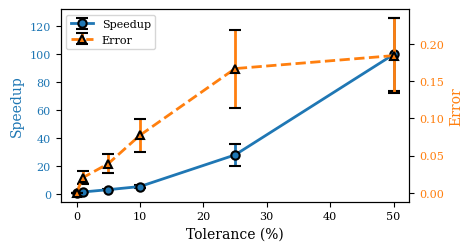

In [24]:
from benchmark._plot_util import *

# get the standard colors of matplotlib
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
print(colors)

# fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(20, 2.5))
fig, ax0 = plt.subplots(figsize=(4.5, 2.5))

# Plot the first dataset on the first y-axis
df1_mean.plot(
    y="speedup", 
    ax=ax0, 
    label="Speedup", 
    yerr=df1_std["speedup"].T, 
    capsize=4, 
    marker='o',
    legend=False,
    # color='b'
)

# Set the label for the first y-axis
ax0.set_ylabel('Speedup', color=colors[0])
ax0.tick_params(axis='y', labelcolor=colors[0])

# Create a second y-axis sharing the same x-axis
ax1 = ax0.twinx()

# Plot the second dataset on the second y-axis
df1_mean.plot(
    y="error", 
    ax=ax1, 
    label="Error", 
    yerr=df1_std["error"].T, 
    capsize=4, 
    # color='r',
    # markersize=500,
    marker='^',
    color=colors[1],
    legend=False,
    linestyle='--',
    # style='o-'
)

# Set the label for the second y-axis
ax1.set_ylabel('Error', color=colors[1])
ax1.tick_params(axis='y', labelcolor=colors[1])

# Set the title and labels
# ax0.set_title('Speedup and Error with Two Y Axes')
ax0.set_xlabel('Tolerance (%)')

# Combine legends
lines, labels = ax0.get_legend_handles_labels()
lines2, labels2 = ax1.get_legend_handles_labels()
ax0.legend(lines + lines2, labels + labels2, loc=0)


In [26]:
fig.savefig("approximation.pdf", bbox_inches='tight')